# Setup

In [1]:
import pandas as pd
from tqdm import tqdm
import re
import json
import nltk
import numpy as np
import matplotlib.pyplot as plt

from random import shuffle

from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import DataCollatorForLanguageModeling, AutoTokenizer, TFAutoModelForCausalLM, AdamWeightDecay
from nltk.corpus import stopwords
from os.path import join, exists

In [24]:
tf.test.is_built_with_cuda()

True

In [23]:
import tensorflow as tf
from tensorflow.python.client import device_lib

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [2]:
from data_utils import character_dict, model_name, preprocess_function, load_df, get_predictions_cached, get_dataframe_for_metrics

from metrics import freq_pairwise_sim, filter_by_weights, get_word_frequency, get_tfidfs, FrequencyChatbotClassifier

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     c:\Users\User\anaconda3\envs\nlp\lib\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
characters = list(character_dict.keys())
# characters.remove('Default')

mass_value = 0.3

In [5]:
# Mount google drive, if in Colaboratory environment
import os
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    base_folder = '/content/drive/My Drive/unibo/NLP_project/BarneyBot'
    os.system("pip install datasets")
    os.system("pip install transformers")
    os.system("pip install rouge_score")
    os.system("pip install -U sentence-transformers")
else:
    # base_folder = os.getcwd()
    base_folder = '..'

out_folder = os.path.join(base_folder, 'Data', 'Characters')

In [6]:
def sentence_preprocessing(sentence):
    sentence = re.sub(r'[^A-Za-z\s]', ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

In [7]:
character_docs = dict()
for character in characters:
    if character == 'Default':
        df = pd.read_csv(os.path.join(out_folder, character, f'{character}.tsv'), 
                         names=[character, 'response'], sep='\t')
        df['response'] = df['response'].apply(lambda x: x[3:])
        df[character] = df[character].apply(lambda x: x[3:])
        character_docs[character] = df['response'].tolist()
    else:
        df = pd.read_csv(os.path.join(out_folder, character, f'{character}.csv'))
        character_docs[character] = df['response'].tolist()

In [8]:
for character in characters:
    for i in tqdm(range(len(character_docs[character]))):
        character_docs[character][i] = sentence_preprocessing(character_docs[character][i])

100%|██████████| 737332/737332 [00:08<00:00, 82960.35it/s]


Divide in train and test

In [9]:
test_size = 0.33
character_docs_train = {}
character_docs_test = {}
for c in characters:
    shuffle(character_docs[c])
    end_idx = int(len(character_docs[c]) * test_size)
    character_docs_train[c] = character_docs[c][end_idx:]
    character_docs_test[c] = character_docs[c][:end_idx]

# Word Frequency

In [10]:
"""wordfreqs = dict()
for character in tqdm(characters):
    wordfreqs[character] = get_word_frequency(' '.join(character_docs[character]))"""

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:27<00:00,  3.50s/it]


In [11]:
"""wordfreqs_reduced = dict()
for character in characters:
    wordfreqs_reduced[character] = filter_by_weights(wordfreqs[character], mass=mass_value)"""

# TF-IDF

In [10]:
tfidf_vectorizer = TfidfVectorizer(input='content', stop_words='english')

In [11]:
tfidfs = get_tfidfs([' '.join(character_docs[character]) for character in characters], characters, tfidf_vectorizer)

c:\Users\User\anaconda3\envs\nlp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [12]:
tfidfs_reduced = dict()
for character in characters:
    tfidfs_reduced[character] = filter_by_weights(tfidfs[character], mass=mass_value)

# WordCloud Plot

In [17]:
"""from wordcloud import WordCloud

def plot_word_cloud(freqdict, cmap='viridis', title=None, plot=False):
    wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                      colormap = cmap, max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 0)

    wordcloud.generate_from_frequencies(freqdict)
    if title:
        plt.title(title)
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.figure()"""

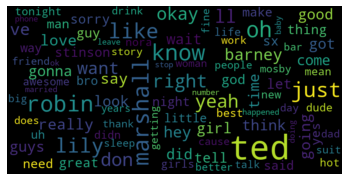

<Figure size 432x288 with 0 Axes>

In [18]:
"""plot_word_cloud(tfidfs_reduced['Barney'])"""

# Frequency Pairwise Similarity

In [13]:
freq_pairwise_sim(tfidfs_reduced['Fry'], tfidfs_reduced['Barney'])

0.47513048026561405

In [14]:
freq_pairwise_sim(tfidfs_reduced['Default'], tfidfs_reduced['Barney'])

0.494064177043276

# Test classifiers on test set 

In [20]:
"""wf_classifier = FrequencyChatbotClassifier(characters, mode='word frequency')
wf_classifier.train(list(character_docs_train.values()))
predictions = []
for c in tqdm(characters):
    prediction = wf_classifier.predict(character_docs_test[c], mass=mass_value)
    predictions.append(
        int(max(prediction, key=prediction.get) == c)
    )

print('Frequency classifier test accuracy: {:.2f}'.format(sum(predictions)/len(predictions)))"""

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.41it/s]

Frequency classifier test accuracy: 1.00


In [15]:
tfidf_classifier = FrequencyChatbotClassifier(characters, mode='tf-idf')
tfidf_classifier.train(list(character_docs_train.values()))
predictions = []
for c in characters:
    prediction = tfidf_classifier.predict(character_docs_test[c], mass=mass_value)
    predictions.append(
        int(max(prediction, key=prediction.get) == c)
    )

print('TF-IDF classifier test accuracy: {:.2f}'.format(sum(predictions)/len(predictions)))

c:\Users\User\anaconda3\envs\nlp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\User\anaconda3\envs\nlp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\User\anaconda3\envs\nlp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\User\anaconda3\envs\nlp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_fea

TF-IDF classifier test accuracy: 1.00


# Test classifiers on chatbot sentences

In [16]:
tfidf_classifier = FrequencyChatbotClassifier(characters, mode='tf-idf')
tfidf_classifier.train(list(character_docs.values()))

In [17]:
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=join("cache"))
tokenizer.pad_token = '#'
data_collator = DataCollatorForLanguageModeling(mlm=False, tokenizer=tokenizer, return_tensors='tf')

In [18]:
### create dataset
n_tests = 1
doc_test = {c:[] for c in characters}
batch_size = 8
override_predictions = False
predictions = {c:[] for c in characters}
raw_predictions = {c:[] for c in characters}
print('Creating dataset...')
if n_tests > 1 and not override_predictions:
    raise Exception('must override previous predictions if you need more tests')

for character in characters:
    print('Character: ', character)
    for i in tqdm(range(n_tests)):
        character_checkpoint = join(out_folder, character, character_dict[character]['checkpoint_folder'])
        model_chatbot = TFAutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=character_checkpoint) if override_predictions else None
        if model_chatbot:
            model_chatbot.compile(optimizer=AdamWeightDecay(learning_rate=2e-5))

        character_hg = load_df(character, base_folder)
        # This transform in a sequence of tokens ours dataset
        tokenized_character_hg = character_hg.map(preprocess_function, batched=False)

        # Define tensorflow datasets
        encoded_test_set = tokenized_character_hg["test"].to_tf_dataset(
            columns=["input_ids", "attention_mask", "labels"],
            shuffle=False,
            batch_size=batch_size,
            collate_fn=data_collator,
        )

        # Takes the testset as sample question 
        sample_questions = character_hg['test']['context/0']

        # Sampling generation method
        predictions_sampling = get_predictions_cached(
            sample_questions,
            model_chatbot,
            character_dict[character]['prediction_filename'] + '_sampling.json',
            "Sampling",
            character,
            tokenizer,
            base_folder,
            override_predictions=override_predictions
        )
                                                    
        sentences = get_dataframe_for_metrics(character_hg['test'], None, None, predictions_sampling, tokenizer)['prd_sampling'].tolist()
        doc_test[character].append([sentence_preprocessing(s) for s in sentences])

Creating dataset...
Character:  Barney


  0%|          | 0/1 [00:00<?, ?it/s]Using custom data configuration default-d78476db32c8db98


100%|██████████| 1/1 [00:00<00:00, 250.00it/s]


Dataset csv downloaded and prepared to cache\csv\default-d78476db32c8db98\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00, 36.55it/s]
46ex [04:03,  5.28s/ex]
  0%|          | 0/1 [04:03<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
### prediction on last test
print('Classification...')
for c in range(len(characters)):
    print('Character: ', characters[c])
    for doc in doc_test[characters[c]]:
        prediction = tfidf_classifier.predict(doc, mass=mass_value)
        raw_predictions[characters[c]].append(prediction)
        predictions[characters[c]].append(
            int(max(prediction, key=prediction.get) == characters[c])
        )

In [ ]:
# raw_predictions

In [ ]:
predictions

In [ ]:
print('TF-IDF classifier test accuracy: {:.2f}'.format(sum([char_pred[-1] for char_pred in predictions.values()])/len(predictions)))

In [ ]:
### save predictions
append_predictions = False
override_predictions = True
predictions_file = join('..', 'Data', 'tfidf_predictions.json')

if append_predictions and exists(predictions_file):
    with open(predictions_file, 'r', encoding='utf-8') as file:
        predictions_dict = json.load(file)
elif override_predictions or not exists(predictions_file):
    predictions_dict = {'one_hot':{c:[] for c in characters}, 'raw_predictions': {c:[] for c in characters}}
else:
    raise NotImplementedError
    
for c in characters:
    predictions_dict['one_hot'][c] += predictions[c]
    predictions_dict['raw_predictions'][c] += raw_predictions[c]

with open(predictions_file, 'w', encoding='utf-8') as file:
    json.dump(predictions_dict, file)



In [ ]:
predictions_dict